<a href="https://colab.research.google.com/github/alina-bogdanovskaya/ML_in_Business_Mar2023/blob/lesson3/ML_in_business_HW03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas_profiling as pp
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix, accuracy_score

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import catboost
from catboost import CatBoostClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


In [3]:
data = pd.read_csv('/content/drive/MyDrive/GB/ML in business/Lection3/train_case2.csv', sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
data['bmi'] = data.weight / (data.height/100)**2

In [6]:
data.loc[data.height < 100, ['height']] = data.height + 100
data.loc[data.ap_hi < 0, ['ap_hi']] = data.ap_hi * -1 
data.loc[data.ap_hi < 30, ['ap_hi']] = data.ap_hi * 10
data.loc[(data.ap_hi > 250) & (data.ap_hi < 500), ['ap_hi']] = data.ap_hi.median()
data.loc[(data.ap_hi > 250) & (data.ap_hi < 10000), ['ap_hi']] = round(data.ap_hi / 10)
data.loc[data.ap_hi > 1000, ['ap_hi']] = round(data.ap_hi / 100)
data.loc[data.ap_lo < 0, ['ap_lo']] = data.ap_lo * -1
data.loc[data.ap_lo > 1500, ['ap_lo']] = round(data.ap_lo / 100) 
data.loc[data.ap_lo > 200, ['ap_lo']] = round(data.ap_lo / 10)
data.loc[data.bmi <= 12, ['weight']] = (data.height / 100)**2 * 21.7
mask = data.ap_lo > data.ap_hi
data.loc[mask, ['ap_hi', 'ap_lo']] = data.loc[mask, ['ap_lo', 'ap_hi']].values
data.loc[data.ap_lo < 20, ['ap_lo']] = data.ap_hi - 40

In [7]:
data.drop(['id', 'bmi'], axis=1, inplace=True)
data['bmi'] = data.weight / (data.height/100)**2

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [9]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(data.drop('cardio', 1), 
                                                    data['cardio'], test_size=0.25, random_state=42)

In [10]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.45260489,  0.05733029, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20235206, -0.84814924, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.04891211,  1.79863709, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.57773131, -0.01232198, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32747848, -0.29093106, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.57874265, -0.7088447 , ...,  0.        ,
         0.        ,  1.        ]])

In [11]:
def plot_cm(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='red')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [12]:
# Logistic Regression

classifier_lr = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(C=0.01, solver='newton-cholesky', random_state=42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_lr, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_lr.fit(X_train, y_train)
y_score_lr = classifier_lr.predict_proba(X_test)[:, 1]

CV score is 0.7930701256897537+-0.007887131817065468


In [13]:
b=1
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test.values, y_score_lr)
# print(precision_lr)
# print(recall_lr)
# print(thresholds_lr)
fscore_lr = (1+b**2)*(precision_lr * recall_lr) / (b**2*precision_lr + recall_lr)
# print(fscore_lr)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix_lr], 
                                                                        fscore_lr[ix_lr],
                                                                        precision_lr[ix_lr],
                                                                        recall_lr[ix_lr]))

roc_auc_lr = roc_auc_score(y_true=y_test, y_score=y_score_lr)
log_loss_score_lr = log_loss(y_true=y_test, y_pred=y_score_lr)
accuracy_lr = accuracy_score(y_true=y_test, y_pred=classifier_lr.predict(X_test))
print(f'roc auc score: {roc_auc_lr}')
print(f'log loss score: {log_loss_score_lr}')
print(f'accuracy: {accuracy_lr}')

Best Threshold=0.419743, F-Score=0.741, Precision=0.703, Recall=0.783
roc auc score: 0.7945221961576754
log loss score: 0.5571964839581172
accuracy: 0.7337142857142858


Confusion matrix, without normalization
[[5772 2916]
 [1914 6898]]


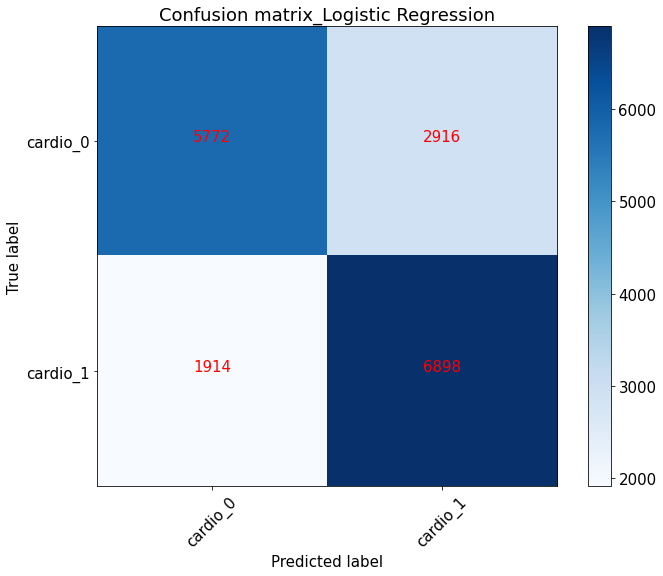

In [14]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, y_score_lr>thresholds_lr[ix_lr])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_lr, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_Logistic Regression')
plt.show()

In [15]:
TN_lr = cnf_matrix_lr[0][0]
FN_lr = cnf_matrix_lr[1][0]
TP_lr = cnf_matrix_lr[1][1]
FP_lr = cnf_matrix_lr[0][1]

TPR_lr = TP_lr/(TP_lr+FN_lr)
FPR_lr = FP_lr/(FP_lr+TN_lr)
TNR_lr = TN_lr/(FP_lr+TN_lr)
TPR_lr, FPR_lr, TNR_lr


(0.7827961870177031, 0.3356353591160221, 0.664364640883978)

In [16]:
# Decision Tree

classifier_dt = Pipeline([
    ('features',feats),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=3, criterion='log_loss')),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_dt, X_train, y_train, cv=5, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_dt.fit(X_train, y_train)
y_score_dt = classifier_dt.predict_proba(X_test)[:, 1]

CV score is 0.7798842276365006+-0.0036430535026412345


In [17]:
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_test.values, y_score_dt)
# print(precision_dt)
# print(recall_dt)
# print(thresholds_dt)
fscore_dt = (1+b**2)*(precision_dt * recall_dt) / (b**2*precision_dt + recall_dt)
# print(fscore_dt)
# locate the index of the largest f score
ix_dt = np.argmax(fscore_dt)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_dt[ix_dt], 
                                                                        fscore_dt[ix_dt],
                                                                        precision_dt[ix_dt],
                                                                        recall_dt[ix_dt]))

roc_auc_dt = roc_auc_score(y_true=y_test, y_score=y_score_dt)
log_loss_score_dt = log_loss(y_true=y_test, y_pred=y_score_dt)
accuracy_dt = accuracy_score(y_true=y_test, y_pred=classifier_dt.predict(X_test))
print(f'roc auc score: {roc_auc_dt}')
print(f'log loss score: {log_loss_score_dt}')
print(f'accuracy: {accuracy_dt}')

Best Threshold=0.419935, F-Score=0.734, Precision=0.649, Recall=0.844
roc auc score: 0.7794357636058814
log loss score: 0.5564948293743703
accuracy: 0.7298285714285714


Confusion matrix, without normalization
[[6755 1933]
 [2795 6017]]


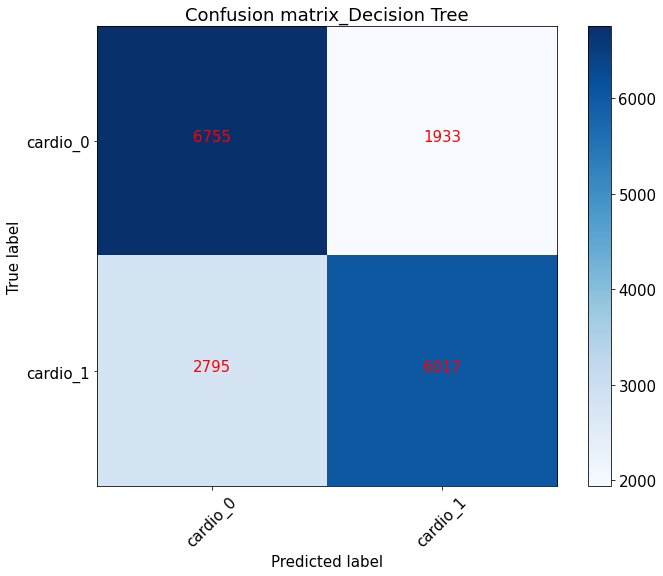

In [18]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_dt = confusion_matrix(y_test, y_score_dt>thresholds_dt[ix_dt])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_dt, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_Decision Tree')
plt.show()

In [19]:
TN_dt = cnf_matrix_dt[0][0]
FN_dt = cnf_matrix_dt[1][0]
TP_dt = cnf_matrix_dt[1][1]
FP_dt = cnf_matrix_dt[0][1]

TPR_dt = TP_dt/(TP_dt+FN_dt)
FPR_dt = FP_dt/(FP_dt+TN_dt)
TNR_dt = TN_dt/(FP_dt+TN_dt)
TPR_dt, FPR_dt, TNR_dt

(0.6828188833408988, 0.22249079189686924, 0.7775092081031307)

In [20]:
# KNN

classifier_knn = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier(n_neighbors=15, metric='manhattan')),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_knn, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_knn.fit(X_train, y_train)
y_score_knn = classifier_knn.predict_proba(X_test)[:, 1]

CV score is 0.7800922168496658+-0.006131080069584845


In [21]:
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test.values, y_score_knn)
# print(precision_knn)
# print(recall_knn)
# print(thresholds_knn)
fscore_knn = (1+b**2)*(precision_knn * recall_knn) / (b**2*precision_knn + recall_knn + sys.float_info.epsilon)
# print(fscore_knn)
# locate the index of the largest f score
ix_knn = np.argmax(fscore_knn)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_knn[ix_knn], 
                                                                        fscore_knn[ix_knn],
                                                                        precision_knn[ix_knn],
                                                                        recall_knn[ix_knn]))

roc_auc_knn = roc_auc_score(y_true=y_test, y_score=y_score_knn)
log_loss_score_knn = log_loss(y_true=y_test, y_pred=y_score_knn)
accuracy_knn = accuracy_score(y_true=y_test, y_pred=classifier_knn.predict(X_test))
print(f'roc auc score: {roc_auc_knn}')
print(f'log loss score: {log_loss_score_knn}')
print(f'accuracy: {accuracy_knn}')

Best Threshold=0.466667, F-Score=0.730, Precision=0.703, Recall=0.758
roc auc score: 0.7798123049600035
log loss score: 0.7308495941224954
accuracy: 0.7241714285714286


Confusion matrix, without normalization
[[6517 2171]
 [2656 6156]]


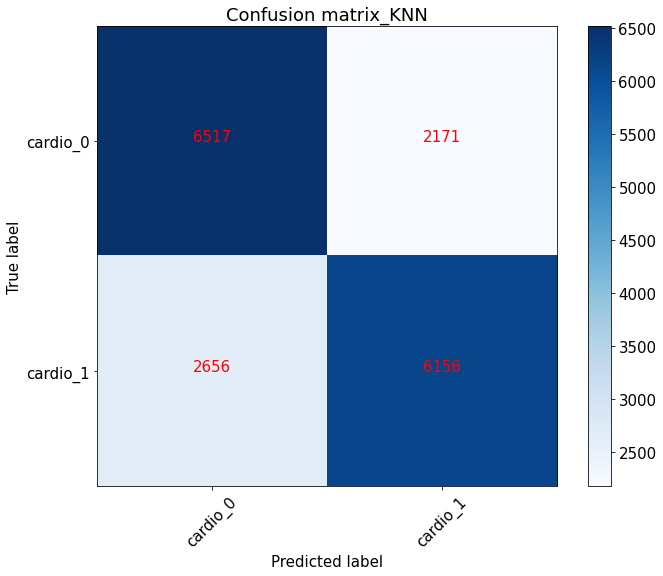

In [22]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_knn = confusion_matrix(y_test, y_score_knn>thresholds_knn[ix_knn])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_knn, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_KNN')
plt.show()

In [23]:
TN_knn = cnf_matrix_knn[0][0]
FN_knn = cnf_matrix_knn[1][0]
TP_knn = cnf_matrix_knn[1][1]
FP_knn = cnf_matrix_knn[0][1]

TPR_knn = TP_knn/(TP_knn+FN_knn)
FPR_knn = FP_knn/(FP_knn+TN_knn)
TNR_knn = TN_knn/(FP_knn+TN_knn)
TPR_knn, FPR_knn, TNR_knn

(0.6985928279618702, 0.24988489871086556, 0.7501151012891344)

In [24]:
# Random Forest

classifier_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=30, max_depth=5, max_features=5)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=15, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.7970973553950724+-0.008971763550440114


In [25]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
# print(precision_rf)
# print(recall_rf)
# print(thresholds_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf + sys.float_info.epsilon)
# print(fscore_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

roc_auc_rf = roc_auc_score(y_true=y_test, y_score=y_score_rf)
log_loss_score_rf = log_loss(y_true=y_test, y_pred=y_score_rf)
accuracy_rf = accuracy_score(y_true=y_test, y_pred=classifier_rf.predict(X_test))
print(f'roc auc score: {roc_auc_rf}')
print(f'log loss score: {log_loss_score_rf}')
print(f'accuracy: {accuracy_rf}')

Best Threshold=0.394701, F-Score=0.743, Precision=0.701, Recall=0.790
roc auc score: 0.7974073630550672
log loss score: 0.5495617013900382
accuracy: 0.7324571428571428


Confusion matrix, without normalization
[[5723 2965]
 [1854 6958]]


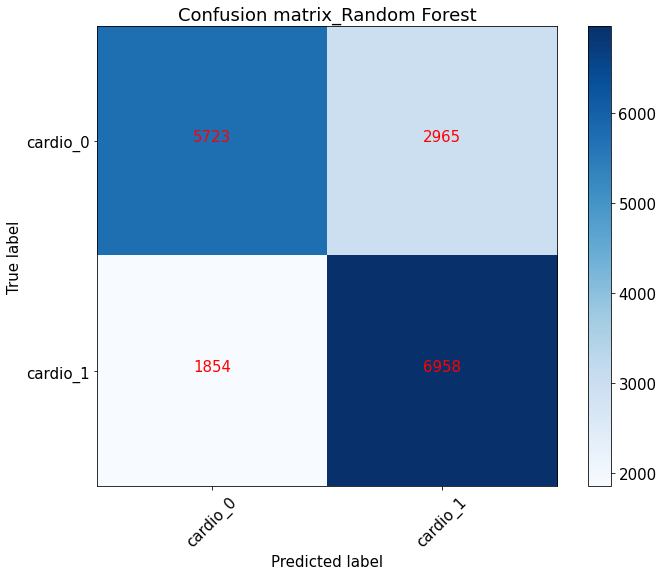

In [26]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_Random Forest')
plt.show()

In [27]:
TN_rf = cnf_matrix_rf[0][0]
FN_rf = cnf_matrix_rf[1][0]
TP_rf = cnf_matrix_rf[1][1]
FP_rf = cnf_matrix_rf[0][1]

TPR_rf = TP_rf/(TP_rf+FN_rf)
FPR_rf = FP_rf/(FP_rf+TN_rf)
TNR_rf = TN_rf/(FP_rf+TN_rf)
TPR_rf, FPR_rf, TNR_rf

(0.7896050839763958, 0.3412753222836096, 0.6587246777163904)

In [28]:
# AdaBoost

classifier_ab = Pipeline([
    ('features',feats),
    ('classifier', AdaBoostClassifier(random_state=42, n_estimators=30)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_ab, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_ab.fit(X_train, y_train)
y_score_ab = classifier_ab.predict_proba(X_test)[:, 1]

CV score is 0.7940917920091648+-0.00693049241630287


In [29]:
precision_ab, recall_ab, thresholds_ab = precision_recall_curve(y_test.values, y_score_ab)
# print(precision_ab)
# print(recall_ab)
# print(thresholds_ab)
fscore_ab = (1+b**2)*(precision_ab * recall_ab) / (b**2*precision_ab + recall_ab + sys.float_info.epsilon)
# print(fscore_ab)
# locate the index of the largest f score
ix_ab = np.argmax(fscore_ab)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_ab[ix_ab], 
                                                                        fscore_ab[ix_ab],
                                                                        precision_ab[ix_ab],
                                                                        recall_ab[ix_ab]))

roc_auc_ab = roc_auc_score(y_true=y_test, y_score=y_score_ab)
log_loss_score_ab = log_loss(y_true=y_test, y_pred=y_score_ab)
accuracy_ab = accuracy_score(y_true=y_test, y_pred=classifier_ab.predict(X_test))
print(f'roc auc score: {roc_auc_ab}')
print(f'log loss score: {log_loss_score_ab}')
print(f'accuracy: {accuracy_ab}')

Best Threshold=0.495159, F-Score=0.742, Precision=0.682, Recall=0.814
roc auc score: 0.7962580416772207
log loss score: 0.6827416212465114
accuracy: 0.7328571428571429


Confusion matrix, without normalization
[[5347 3341]
 [1641 7171]]


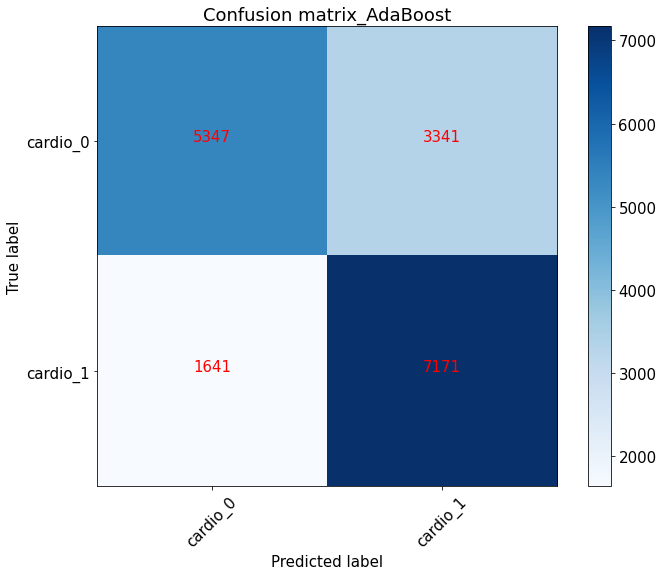

In [30]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_ab = confusion_matrix(y_test, y_score_ab>thresholds_ab[ix_ab])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_ab, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_AdaBoost')
plt.show()

In [31]:
TN_ab = cnf_matrix_ab[0][0]
FN_ab = cnf_matrix_ab[1][0]
TP_ab = cnf_matrix_ab[1][1]
FP_ab = cnf_matrix_ab[0][1]

TPR_ab = TP_ab/(TP_ab+FN_ab)
FPR_ab = FP_ab/(FP_ab+TN_ab)
TNR_ab = TN_ab/(FP_ab+TN_ab)
TPR_ab, FPR_ab, TNR_ab

(0.8137766681797549, 0.3845534069981584, 0.6154465930018416)

In [32]:
# Gradient Boosting

classifier_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=30, max_depth=3)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_gb, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_gb.fit(X_train, y_train)
y_score_gb = classifier_gb.predict_proba(X_test)[:, 1]

CV score is 0.7993126909919063+-0.006536611423254695


In [33]:
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_test.values, y_score_gb)
# print(precision_gb)
# print(recall_gb)
# print(thresholds_gb)
fscore_gb = (1+b**2)*(precision_gb * recall_gb) / (b**2*precision_gb + recall_gb + sys.float_info.epsilon)
# print(fscore_gb)
# locate the index of the largest f score
ix_gb = np.argmax(fscore_gb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_gb[ix_gb], 
                                                                        fscore_gb[ix_gb],
                                                                        precision_gb[ix_gb],
                                                                        recall_gb[ix_gb]))

roc_auc_gb = roc_auc_score(y_true=y_test, y_score=y_score_gb)
log_loss_score_gb = log_loss(y_true=y_test, y_pred=y_score_gb)
accuracy_gb = accuracy_score(y_true=y_test, y_pred=classifier_gb.predict(X_test))
print(f'roc auc score: {roc_auc_gb}')
print(f'log loss score: {log_loss_score_gb}')
print(f'accuracy: {accuracy_gb}')

Best Threshold=0.403103, F-Score=0.743, Precision=0.708, Recall=0.781
roc auc score: 0.7997188325772071
log loss score: 0.545563158232193
accuracy: 0.7359428571428571


Confusion matrix, without normalization
[[5866 2822]
 [1954 6858]]


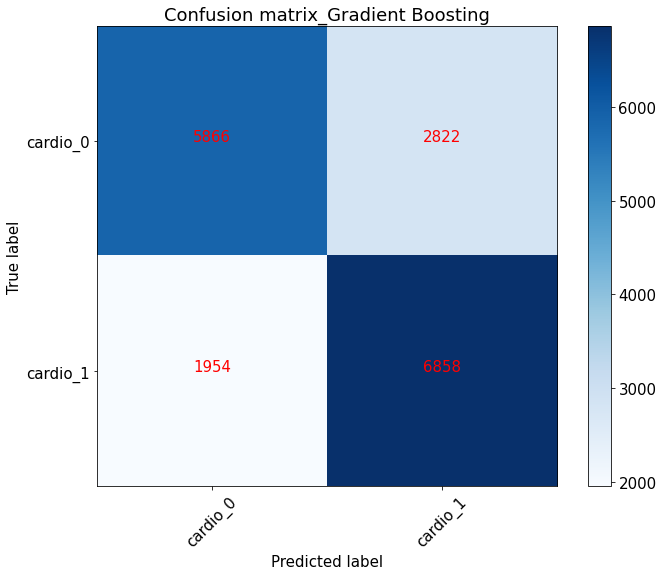

In [34]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, y_score_gb>thresholds_gb[ix_gb])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_gb, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_Gradient Boosting')
plt.show()

In [35]:
TN_gb = cnf_matrix_gb[0][0]
FN_gb = cnf_matrix_gb[1][0]
TP_gb = cnf_matrix_gb[1][1]
FP_gb = cnf_matrix_gb[0][1]

TPR_gb = TP_gb/(TP_gb+FN_gb)
FPR_gb = FP_gb/(FP_gb+TN_gb)
TNR_gb = TN_gb/(FP_gb+TN_gb)
TPR_gb, FPR_gb, TNR_gb

(0.7782569223785747, 0.3248158379373849, 0.6751841620626151)

In [36]:
# XGB

classifier_xgb = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state=42, eta=0.1, max_depth=4)),
])
# max_depth=3, eta=0.05, learning_rate=0.001, n_estimators=150

#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_xgb, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_xgb.fit(X_train, y_train)
y_score_xgb = classifier_xgb.predict_proba(X_test)[:, 1]

CV score is 0.8027718389761193+-0.006700142405060561


In [37]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test.values, y_score_xgb)
# print(precision_xgb)
# print(recall_xgb)
# print(thresholds_xgb)
fscore_xgb = (1+b**2)*(precision_xgb * recall_xgb) / (b**2*precision_xgb + recall_xgb)
# print(fscore_xgb)
# locate the index of the largest f score
ix_xgb = np.argmax(fscore_xgb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_xgb[ix_xgb], 
                                                                        fscore_xgb[ix_xgb],
                                                                        precision_xgb[ix_xgb],
                                                                        recall_xgb[ix_xgb]))

roc_auc_xgb = roc_auc_score(y_true=y_test, y_score=y_score_xgb)
log_loss_score_xgb = log_loss(y_true=y_test, y_pred=y_score_xgb)
accuracy_xgb = accuracy_score(y_true=y_test, y_pred=classifier_xgb.predict(X_test))
print(f'roc auc score: {roc_auc_xgb}')
print(f'log loss score: {log_loss_score_xgb}')
print(f'accuracy: {accuracy_xgb}')

Best Threshold=0.385136, F-Score=0.747, Precision=0.697, Recall=0.803
roc auc score: 0.8033832124743674
log loss score: 0.5384035863339669
accuracy: 0.7378857142857143


Confusion matrix, without normalization
[[5616 3072]
 [1735 7077]]


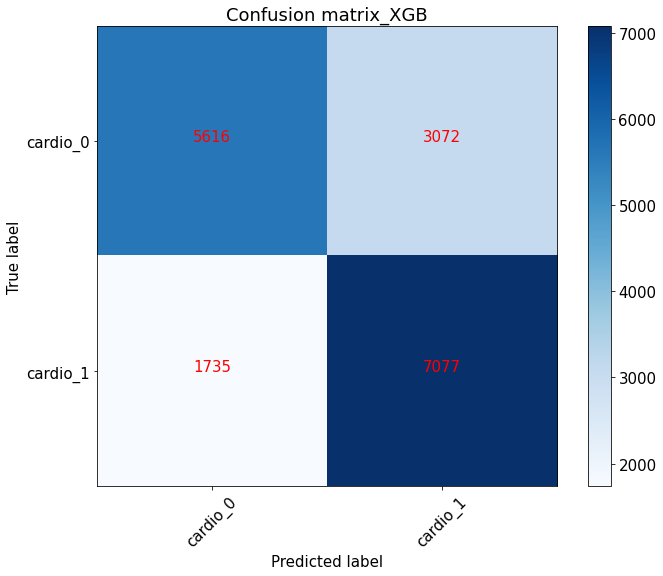

In [38]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_xgb = confusion_matrix(y_test, y_score_xgb>thresholds_xgb[ix_xgb])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_xgb, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_XGB')
plt.show()

In [39]:
TN_xgb = cnf_matrix_xgb[0][0]
FN_xgb = cnf_matrix_xgb[1][0]
TP_xgb = cnf_matrix_xgb[1][1]
FP_xgb = cnf_matrix_xgb[0][1]

TPR_xgb = TP_xgb/(TP_xgb+FN_xgb)
FPR_xgb = FP_xgb/(FP_xgb+TN_xgb)
TNR_xgb = TN_xgb/(FP_xgb+TN_xgb)
TPR_xgb, FPR_xgb, TNR_xgb

(0.803109396277803, 0.35359116022099446, 0.6464088397790055)

In [40]:
# Light GBM

classifier_lgbm = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state=42, max_depth=5, learning_rate=0.05, n_estimators=200)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_lgbm, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_lgbm.fit(X_train, y_train)
y_score_lgbm = classifier_lgbm.predict_proba(X_test)[:, 1]

CV score is 0.8027192233466067+-0.006297487444856684


In [41]:
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(y_test.values, y_score_lgbm)
# print(precision_lgbm)
# print(recall_lgbm)
# print(thresholds_lgbm)
fscore_lgbm = (1+b**2)*(precision_lgbm * recall_lgbm) / (b**2*precision_lgbm + recall_lgbm + sys.float_info.epsilon)
# print(fscore_lgbm)
# locate the index of the largest f score
ix_lgbm = np.argmax(fscore_lgbm)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lgbm[ix_lgbm], 
                                                                        fscore_lgbm[ix_lgbm],
                                                                        precision_lgbm[ix_lgbm],
                                                                        recall_lgbm[ix_lgbm]))

roc_auc_lgbm = roc_auc_score(y_true=y_test, y_score=y_score_lgbm)
log_loss_score_lgbm = log_loss(y_true=y_test, y_pred=y_score_lgbm)
accuracy_lgbm = accuracy_score(y_true=y_test, y_pred=classifier_lgbm.predict(X_test))
print(f'roc auc score: {roc_auc_lgbm}')
print(f'log loss score: {log_loss_score_lgbm}')
print(f'accuracy: {accuracy_lgbm}')

Best Threshold=0.396551, F-Score=0.746, Precision=0.706, Recall=0.790
roc auc score: 0.8027004353367958
log loss score: 0.5393542322239654
accuracy: 0.7377714285714285


Confusion matrix, without normalization
[[5798 2890]
 [1856 6956]]


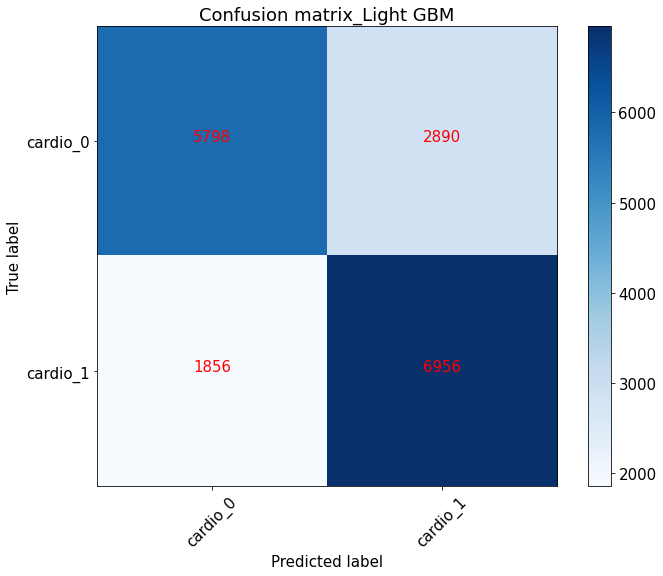

In [42]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lgbm = confusion_matrix(y_test, y_score_lgbm>thresholds_lgbm[ix_lgbm])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_lgbm, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_Light GBM')
plt.show()

In [43]:
TN_lgbm = cnf_matrix_lgbm[0][0]
FN_lgbm = cnf_matrix_lgbm[1][0]
TP_lgbm = cnf_matrix_lgbm[1][1]
FP_lgbm = cnf_matrix_lgbm[0][1]

TPR_lgbm = TP_lgbm/(TP_lgbm+FN_lgbm)
FPR_lgbm = FP_lgbm/(FP_lgbm+TN_lgbm)
TNR_lgbm = TN_lgbm/(FP_lgbm+TN_lgbm)
TPR_lgbm, FPR_lgbm, TNR_lgbm

(0.7893781207444394, 0.3326427255985267, 0.6673572744014733)

In [44]:
# CatBoost

classifier_cb = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state=42, verbose=0, iterations=50, learning_rate=0.01, depth=2)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_cb, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_cb.fit(X_train, y_train)
y_score_cb = classifier_cb.predict_proba(X_test)[:, 1]

CV score is 0.782540925417395+-0.007593443189901855


In [45]:
precision_cb, recall_cb, thresholds_cb = precision_recall_curve(y_test.values, y_score_cb)
# print(precision_cb)
# print(recall_cb)
# print(thresholds_cb)
fscore_cb = (1+b**2)*(precision_cb * recall_cb) / (b**2*precision_cb + recall_cb + sys.float_info.epsilon)
# print(fscore_cb)
# locate the index of the largest f score
ix_cb = np.argmax(fscore_cb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_cb[ix_cb], 
                                                                        fscore_cb[ix_cb],
                                                                        precision_cb[ix_cb],
                                                                        recall_cb[ix_cb]))

roc_auc_cb = roc_auc_score(y_true=y_test, y_score=y_score_cb)
log_loss_score_cb = log_loss(y_true=y_test, y_pred=y_score_cb)
accuracy_cb = accuracy_score(y_true=y_test, y_pred=classifier_cb.predict(X_test))
print(f'roc auc score: {roc_auc_cb}')
print(f'log loss score: {log_loss_score_cb}')
print(f'accuracy: {accuracy_cb}')

Best Threshold=0.455449, F-Score=0.737, Precision=0.684, Recall=0.799
roc auc score: 0.7823144452797082
log loss score: 0.6211954347008072
accuracy: 0.7269714285714286


Confusion matrix, without normalization
[[6710 1978]
 [2768 6044]]


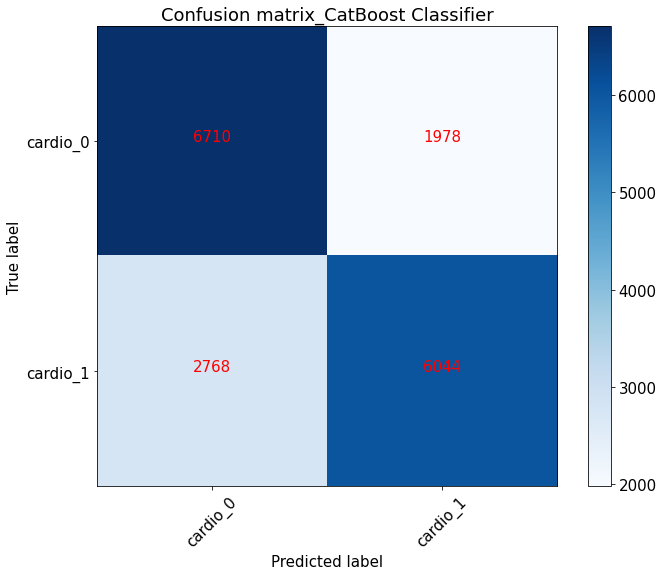

In [46]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_cb = confusion_matrix(y_test, y_score_cb>thresholds_cb[ix_cb])
plt.figure(figsize=(10, 8))
plot_cm(cnf_matrix_cb, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_CatBoost Classifier')
plt.show()

In [47]:
TN_cb = cnf_matrix_cb[0][0]
FN_cb = cnf_matrix_cb[1][0]
TP_cb = cnf_matrix_cb[1][1]
FP_cb = cnf_matrix_cb[0][1]

TPR_cb = TP_cb/(TP_cb+FN_cb)
FPR_cb = FP_cb/(FP_cb+TN_cb)
TNR_cb = TN_cb/(FP_cb+TN_cb)
TPR_cb, FPR_cb, TNR_cb

(0.6858828869723105, 0.22767034990791896, 0.772329650092081)

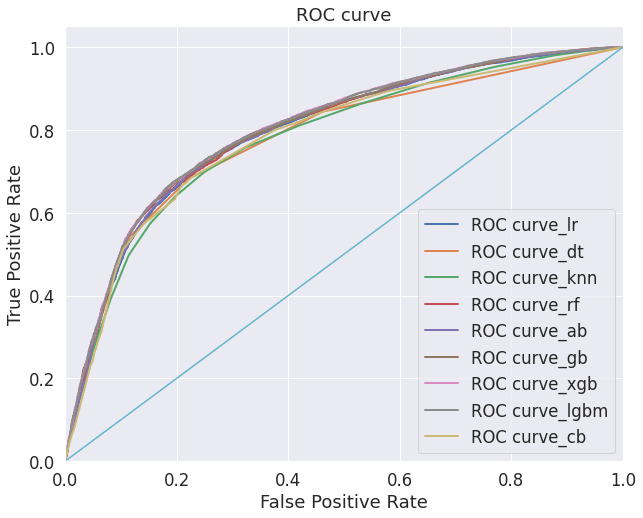

In [48]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr_lr, tpr_lr, thresholds_ = roc_curve(y_test, y_score_lr, pos_label=1)
fpr_dt, tpr_dt, thresholds_ = roc_curve(y_test, y_score_dt, pos_label=1)
fpr_knn, tpr_knn, thresholds_ = roc_curve(y_test, y_score_knn, pos_label=1)
fpr_rf, tpr_rf, thresholds_ = roc_curve(y_test, y_score_rf, pos_label=1)
fpr_ab, tpr_ab, thresholds_ = roc_curve(y_test, y_score_ab, pos_label=1)
fpr_gb, tpr_gb, thresholds_ = roc_curve(y_test, y_score_gb, pos_label=1)
fpr_xgb, tpr_xgb, thresholds_ = roc_curve(y_test, y_score_xgb, pos_label=1)
fpr_lgbm, tpr_lgbm, thresholds_ = roc_curve(y_test, y_score_lgbm, pos_label=1)
fpr_cb, tpr_cb, thresholds_ = roc_curve(y_test, y_score_cb, pos_label=1)

lw = 2
plt.plot(fpr_lr, tpr_lr, lw=lw, label='ROC curve_lr')
plt.plot(fpr_dt, tpr_dt, lw=lw, label='ROC curve_dt')
plt.plot(fpr_knn, tpr_knn, lw=lw, label='ROC curve_knn')
plt.plot(fpr_rf, tpr_rf, lw=lw, label='ROC curve_rf')
plt.plot(fpr_ab, tpr_ab, lw=lw, label='ROC curve_ab')
plt.plot(fpr_gb, tpr_gb, lw=lw, label='ROC curve_gb')
plt.plot(fpr_xgb, tpr_xgb, lw=lw, label='ROC curve_xgb')
plt.plot(fpr_lgbm, tpr_lgbm, lw=lw, label='ROC curve_lgbm')
plt.plot(fpr_cb, tpr_cb, lw=lw, label='ROC curve_cb')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.savefig("ROC.png")
plt.show()

In [49]:
metrics = {'Model': ['Logistic Regression', 
                     'Decision Tree', 
                     'KNN', 
                     'Random Forest', 
                     'AdaBoost', 
                     'Gradient Boosting', 
                     'XGB', 
                     'Light GBM', 
                     'CatBoost'],
           'Threshold': [thresholds_lr[ix_lr], 
                         thresholds_dt[ix_dt], 
                         thresholds_knn[ix_knn],
                         thresholds_rf[ix_rf],
                         thresholds_ab[ix_ab],
                         thresholds_gb[ix_gb],
                         thresholds_xgb[ix_xgb], 
                         thresholds_lgbm[ix_lgbm],
                         thresholds_cb[ix_cb]], 
            'F_score': [fscore_lr[ix_lr],
                        fscore_dt[ix_dt],
                        fscore_knn[ix_knn],
                        fscore_rf[ix_rf],
                        fscore_ab[ix_ab],
                        fscore_gb[ix_gb],
                        fscore_xgb[ix_xgb],
                        fscore_lgbm[ix_lgbm],
                        fscore_cb[ix_cb]],
            'Precision': [precision_lr[ix_lr],
                          precision_dt[ix_dt],
                          precision_knn[ix_knn],
                          precision_rf[ix_rf],
                          precision_ab[ix_ab],
                          precision_gb[ix_gb],
                          precision_xgb[ix_xgb],
                          precision_lgbm[ix_lgbm],
                          precision_cb[ix_cb]],
            'Recall': [recall_lr[ix_lr],
                       recall_dt[ix_dt],
                       recall_knn[ix_knn],
                       recall_rf[ix_rf],
                       recall_ab[ix_ab],
                       recall_gb[ix_gb],
                       recall_xgb[ix_xgb],
                       recall_lgbm[ix_lgbm],
                       recall_cb[ix_cb]],
           'Accuracy': [accuracy_lr, 
                        accuracy_dt,
                        accuracy_knn, 
                        accuracy_rf, 
                        accuracy_ab, 
                        accuracy_gb, 
                        accuracy_xgb, 
                        accuracy_lgbm,
                        accuracy_cb],
           'ROC_AUC': [roc_auc_lr, 
                       roc_auc_dt,
                       roc_auc_knn, 
                       roc_auc_rf, 
                       roc_auc_ab, 
                       roc_auc_gb, 
                       roc_auc_xgb, 
                       roc_auc_lgbm,
                       roc_auc_cb],
           'Log_loss_score': [log_loss_score_lr, 
                              log_loss_score_dt,
                              log_loss_score_knn, 
                              log_loss_score_rf, 
                              log_loss_score_ab, 
                              log_loss_score_gb, 
                              log_loss_score_xgb,
                              log_loss_score_lgbm,
                              log_loss_score_cb],
           'False Positive Rate': [FPR_lr, FPR_dt, FPR_knn, FPR_rf, FPR_ab, FPR_gb, FPR_xgb, FPR_lgbm, FPR_cb],
           'True Negative Rate': [TNR_lr, TNR_dt, TNR_knn, TNR_rf, TNR_ab, TNR_gb, TNR_xgb, TNR_lgbm, TNR_cb]}

result = pd.DataFrame(metrics)
result

,Model,Threshold,F_score,Precision,Recall,Accuracy,ROC_AUC,Log_loss_score,False Positive Rate,True Negative Rate
0,Logistic Regression,0.419743,0.740753,0.702904,0.782910,0.733714,0.794522,0.557196,0.335635,0.664365
1,Decision Tree,0.419935,0.734100,0.649411,0.844190,0.729829,0.779436,0.556495,0.222491,0.777509
2,KNN,0.466667,0.729805,0.703485,0.758171,0.724171,0.779812,0.730850,0.249885,0.750115
3,Random Forest,0.394701,0.743077,0.701279,0.790172,0.732457,0.797407,0.549562,0.341275,0.658725
4,AdaBoost,0.495159,0.742446,0.682294,0.814231,0.732857,0.796258,0.682742,0.384553,0.615447
5,Gradient Boosting,0.403103,0.742700,0.708183,0.780754,0.735943,0.799719,0.545563,0.324816,0.675184
6,XGB,0.385136,0.746546,0.697340,0.803223,0.737886,0.803383,0.538404,0.353591,0.646409
7,Light GBM,0.396551,0.745794,0.706497,0.789719,0.737771,0.802700,0.539354,0.332643,0.667357
8,CatBoost,0.455449,0.736914,0.683929,0.798797,0.726971,0.782314,0.621195,0.227670,0.772330


In [57]:
def business_thr_calibration(y_test, y_score, thresholds, test_price=100, early_treatment=100, late_treatment=1000):
  business_thr = 0
  r1_r2_ = 0
  r1_r3_ = 0
  r2_r3_ = 0
  LTC_ = - 10000000
  OTC_ = - 10000000
  MLC_ = - 10000000

  r2 = []
  n = 50
  for opt_business_thr in np.linspace(0, 1, n).tolist():
    cm = confusion_matrix(y_test, y_score > (opt_business_thr))

    LTC = ((cm[1][0] + cm[1][1])) * late_treatment
    OTC = np.sum(cm) * test_price + ((cm[1][0] + cm[1][1])) * early_treatment
    MLC = ((cm[0][1] + cm[1][1])) * test_price + (cm[1][1]) * early_treatment + np.sum(cm[1][0]) * late_treatment

    r2_r3 = OTC - MLC
    r1_r2 = LTC - OTC
    r1_r3 = LTC - MLC

    if r2_r3_ < r2_r3:
      business_thr = opt_business_thr
      r1_r2_ = r1_r2
      r1_r3_ = r1_r3
      r2_r3_ = r2_r3
      LTC_ = LTC
      OTC_ = OTC
      MLC_ = MLC

    r2.append(r2_r3)

  print(f'Расходы на лечение при ожидании симптомов: {LTC}')
  print(f'Расходы на тесты всем и раннее лечение больных: {OTC}')
  print(f'Расходы при использовании алгоритма ML: {MLC}')
  print(f'Разница не делать тесты - расходы с ML: {r1_r3_}')
  print(f'Разница не делать тесты - сделать тесты всем: {r1_r2_}')
  print(f'Разница делать тесты всем - сделать тесты по результатам ML: {r2_r3_}')

  plt.plot(np.linspace(0, 1, n), r2)
  plt.grid
  plt.show()

  return business_thr


Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21483000
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 1923000


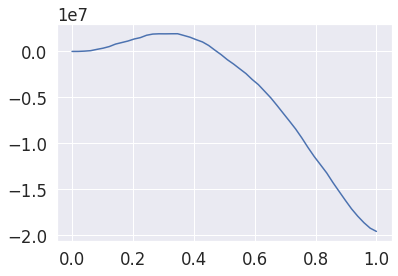

0.3469387755102041
0.4197425557370595


In [58]:
business_thr_lr = business_thr_calibration(y_test, y_score_lr,
                                           thresholds_lr[ix_lr],
                                           test_price=1400, 
                                           early_treatment=15000, 
                                           late_treatment=20000)

print(f'{business_thr_lr}')
print(f'{thresholds_lr[ix_lr]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21158000
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 1598000


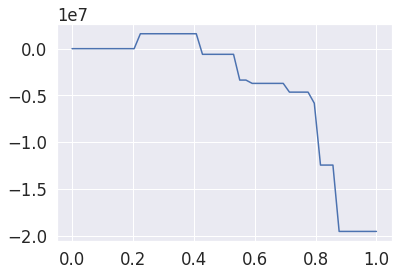

0.22448979591836732
0.41993526275704496


In [59]:
business_thr_dt = business_thr_calibration(y_test, y_score_dt,
                                           thresholds_dt[ix_dt],
                                           test_price=1400, 
                                           early_treatment=15000, 
                                           late_treatment=20000)

print(f'{business_thr_dt}')
print(f'{thresholds_dt[ix_dt]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21065800
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 1505800


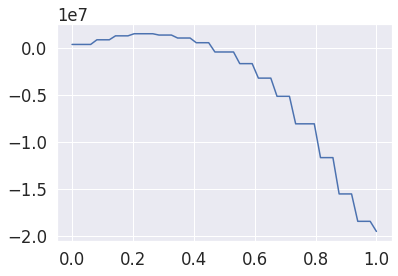

0.2040816326530612
0.4666666666666667


In [60]:
business_thr_knn = business_thr_calibration(y_test, y_score_knn,
                                            thresholds_knn[ix_knn],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_knn}')
print(f'{thresholds_knn[ix_knn]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21579600
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 2019600


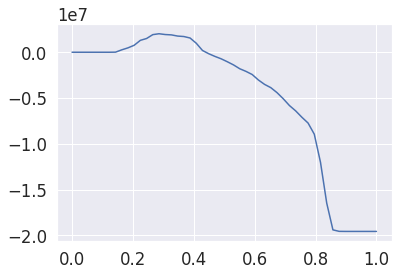

0.2857142857142857
0.3947013263515301


In [61]:
business_thr_rf = business_thr_calibration(y_test, y_score_rf,
                                            thresholds_rf[ix_rf],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_rf}')
print(f'{thresholds_rf[ix_rf]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21335800
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 1775800


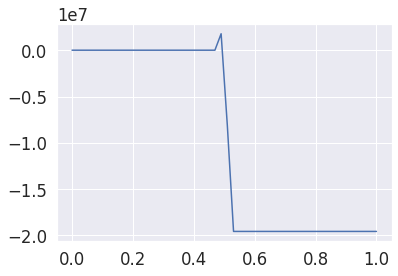

0.4897959183673469
0.4951592668609721


In [62]:
business_thr_ab = business_thr_calibration(y_test, y_score_ab,
                                            thresholds_ab[ix_ab],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_ab}')
print(f'{thresholds_ab[ix_ab]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21627800
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 2067800


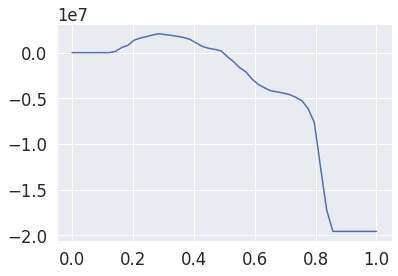

0.2857142857142857
0.40310312753644084


In [64]:
business_thr_gb = business_thr_calibration(y_test, y_score_gb,
                                            thresholds_gb[ix_gb],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_gb}')
print(f'{thresholds_gb[ix_gb]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21800600
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 2240600


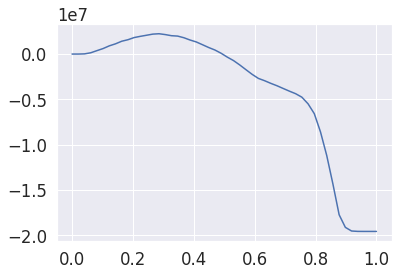

0.2857142857142857
0.385136216878891


In [65]:
business_thr_xgb = business_thr_calibration(y_test, y_score_xgb,
                                            thresholds_xgb[ix_xgb],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_xgb}')
print(f'{thresholds_xgb[ix_xgb]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21753600
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 2193600


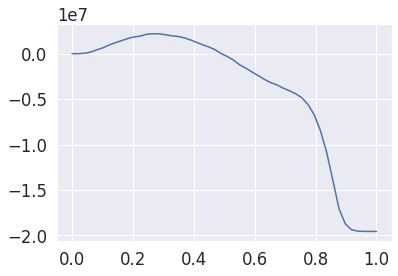

0.26530612244897955
0.39655063593457146


In [66]:
business_thr_lgbm = business_thr_calibration(y_test, y_score_lgbm,
                                            thresholds_lgbm[ix_lgbm],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_lgbm}')
print(f'{thresholds_lgbm[ix_lgbm]}')

Расходы на лечение при ожидании симптомов: 176240000
Расходы на тесты всем и раннее лечение больных: 156680000
Расходы при использовании алгоритма ML: 176240000
Разница не делать тесты - расходы с ML: 21198000
Разница не делать тесты - сделать тесты всем: 19560000
Разница делать тесты всем - сделать тесты по результатам ML: 1638000


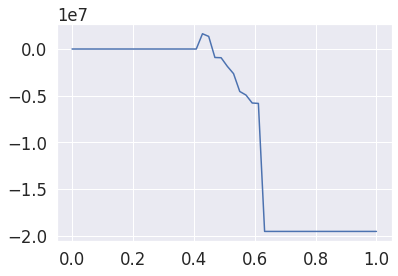

0.42857142857142855
0.455449039819047


In [67]:
business_thr_cb = business_thr_calibration(y_test, y_score_cb,
                                            thresholds_cb[ix_cb],
                                            test_price=1400, 
                                            early_treatment=15000, 
                                            late_treatment=20000)

print(f'{business_thr_cb}')
print(f'{thresholds_cb[ix_cb]}')

К сожалению, ни одна из моделей не показала очень хороших результатов. При тюнинге гиперпараметров удавалось добиться только значительного ухудшения метрик и лишь незначительного улучшения. Видимо, дело в данных, которых недостаточно для построения более точных моделей